In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, accuracy_score, f1_score
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#Importing the csv file

In [ ]:
n=pd.read_csv('/content/drive/MyDrive/heart.csv')

In [ ]:
print(n)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  
0      172              N      0.0       

#Converting categorical values

In [ ]:
le_Sex=LabelEncoder()
le_ChestPainType=LabelEncoder()
le_RestingECG=LabelEncoder()
le_ExerciseAngina=LabelEncoder()
le_ST_Slope=LabelEncoder()
n['Sex']=le_Sex.fit_transform(n['Sex'])
n['ChestPainType']=le_ChestPainType.fit_transform(n['ChestPainType'])
n['RestingECG']=le_RestingECG.fit_transform(n['RestingECG'])
n['ExerciseAngina']=le_ExerciseAngina.fit_transform(n['ExerciseAngina'])
n['ST_Slope']=le_ST_Slope.fit_transform(n['ST_Slope'])
print(n)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1         41          147          0           1   
1     49    0              2         55           40          0           1   
2     37    1              1         31          141          0           2   
3     48    0              0         39           72          0           1   
4     54    1              2         49           53          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3         14          122          0           1   
914   68    1              0         45           51          1           1   
915   57    1              0         31            9          0           1   
916   57    0              1         31           94          0           0   
917   38    1              2         39           35          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

we need to see for missing values

In [ ]:
df=pd.DataFrame(n)
X_missing_values=df.isna().sum()
print(X_missing_values)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


#Spliting the Dataset into training and testing

In [ ]:
X=n.drop(columns='HeartDisease')
y=n['HeartDisease']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
795   42    1              2        120          240          1           1   
25    36    1              2        130          209          0           1   
84    56    1              0        150          213          1           1   
10    37    0              2        130          211          0           1   
344   51    1              0        120            0          1           1   
..   ...  ...            ...        ...          ...        ...         ...   
106   48    0              0        120          254          0           2   
270   45    1              0        120          225          0           1   
860   60    1              0        130          253          0           1   
435   60    1              0        152            0          0           2   
102   40    0              0        150          392          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
795

In [ ]:
d=n['HeartDisease'].value_counts()
print(d)

HeartDisease
1    508
0    410
Name: count, dtype: int64


#we are using SMOTE to balance the HeartDisease label

In [ ]:
from collections import Counter

X_train_resample,y_train_resample=SMOTE(random_state=42).fit_resample(X_train,y_train)
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resample))

Class distribution before SMOTE: Counter({1: 401, 0: 333})
Class distribution after SMOTE: Counter({0: 401, 1: 401})


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler_x_train=scaler.fit_transform(X_train_resample)
scaler_x_test=scaler.fit_transform(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    }
}

cv = StratifiedKFold(n_splits=5)

y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Store the best models and their scores
best_models = {}
for model_name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=cv, scoring='f1_macro')
    grid_search.fit(scaler_x_train, y_train_resample)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate the best model on the test set
for model_name, model in best_models.items():
    y_pred = model.predict(scaler_x_train)
    y_pred_proba = model.predict_proba(scaler_x_test)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Plot ROC curve for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])


ValueError: Found input variables with inconsistent numbers of samples: [6, 802]

In [ ]:
models={
    'logistic':LogisticRegression(max_iter=500),
    'svm':SVC(kernel='rbf',C=1,gamma='auto'),
    'randomforest':RandomForestClassifier(),
    'Decision':DecisionTreeClassifier(),
    'knn':KNeighborsClassifier(),
    'xgboost':xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(verbose=-1),
}
accuracy_scores = dict()
f1_scores = dict()
roc_curve_details = dict()

In [ ]:
for model_name,model in models.items():
    model.fit(scaler_x_train,y_train_resample)
    y_pred=model.predict(scaler_x_test)

    accuracy_scores[model_name] = accuracy_score(y_test,y_pred) * 100
    f1_scores[model_name] = f1_score(y_test,y_pred) * 100
    fpr, tpr, _ = roc_curve(y_test,y_pred)
    roc_curve_details[model_name] = {'tpr': tpr, 'fpr': fpr}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print("="*80)
print("|\tModel Name\tAccuracy Score\tF1 Score\tArea Under Curve       |")
print("="*80)
for k in accuracy_scores.keys():
     print(f"|{k:^25}{accuracy_scores[k]:>10.2f}{f1_scores[k]:>12.2f}{auc(roc_curve_details[k]['fpr'], roc_curve_details[k]['tpr']):>18.2f}\t       |")
print("="*80)


|	Model Name	Accuracy Score	F1 Score	Area Under Curve       |
|        logistic              82.61       84.00              0.83	       |
|           svm                87.50       89.00              0.88	       |
|      randomforest            86.41       88.04              0.86	       |
|        Decision              85.87       87.50              0.86	       |
|           knn                81.52       83.33              0.82	       |
|         xgboost              63.04       66.99              0.63	       |
|        LightGBM              86.41       87.80              0.87	       |


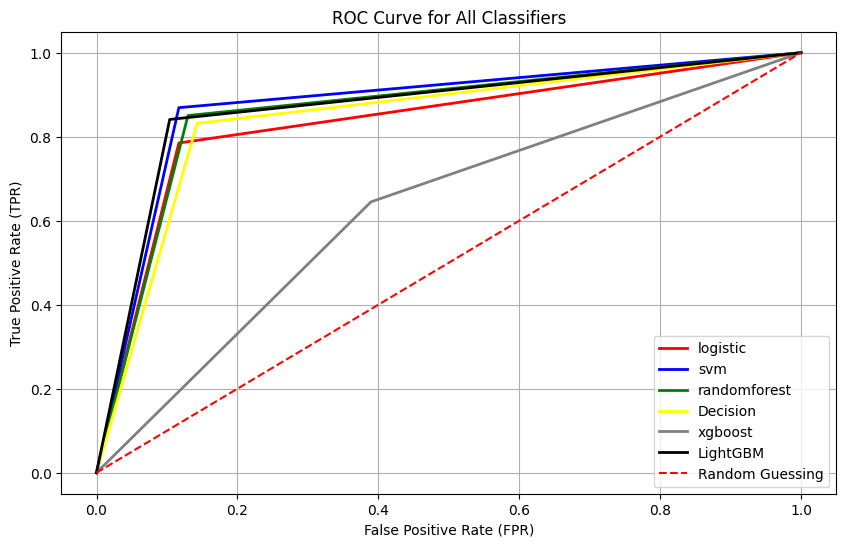

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'yellow', 'gray', 'black']
i = 0
for model in roc_curve_details:
    plt.plot(roc_curve_details[model]['fpr'], roc_curve_details[model]['tpr'], color=colors[i], label=model, linewidth=2)
    i += 1
plt.plot([0, 1], [0, 1], color='red', linestyle="--", label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for All Classifiers")
plt.legend()
plt.grid(True)
plt.show()